In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./src")

In [2]:
from models import *
import rosbag
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from cv_bridge import CvBridge
from torch2trt import torch2trt
import cv2
img_size = 416

In [3]:
model_def="/home/xuhao/swarm_ws/src/swarm_yolo/config/yolov3-tiny-1class.cfg"
weights_path="/home/xuhao/swarm_ws/src/swarm_yolo/weights/yolov3-tiny_drone.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet(model_def, img_size=img_size).to(device)
model_backbone = DarknetBackbone(model_def, img_size=img_size).to(device)
model_end = DarknetEnd(model_def, img_size=img_size).to(device)
model_backbone.load_state_dict(torch.load(weights_path))
model_end.load_state_dict(torch.load(weights_path))
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [4]:
bag = rosbag.Bag("/home/xuhao/bags/swarm_one_drone_reproject_2019-08-18-15-37-47.bag")
for topic, msg, t in bag.read_messages(topics=["/camera/infra1/image_rect_raw", "/camera/depth/image_rect_raw"]):
    if topic == "/camera/infra1/image_rect_raw":
        cam_msg = msg
        break
img_gray = CvBridge().imgmsg_to_cv2(cam_msg, "mono8")
img_ = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
loader = transforms.Compose([
    transforms.ToTensor(),
])


img_size = 416
img_ = cv2.resize(img_ , (img_size, img_size))

image = loader(img_).cuda()

In [5]:
xs = model(image.unsqueeze(0))

In [6]:
x, x8 = model_backbone(image.unsqueeze(0))
xn = model_end(x, x8)
print(torch.max(xn - xs))

RuntimeError: The size of tensor a (13) must match the size of tensor b (6) at non-singleton dimension 3

In [7]:
model_backbone = DarknetBackbone(model_def, img_size=img_size).to(device)
model_backbone.load_state_dict(torch.load(weights_path))
x, x8 = model_backbone(image.unsqueeze(0))
xn = model_end(x, x8)
print("Staring conversion...")
model_trt = torch2trt(model_backbone, [image.unsqueeze(0)], fp16_mode=True)
print("Conversiong done")
x2, x82 = model_trt(image.unsqueeze(0))
xn2 = model_end(x2, x82)

print(torch.max(x - x2).cpu().detach().numpy())
print(torch.max(x8 - x82).cpu().detach().numpy())
print(torch.max(xn - xn2).cpu().detach().numpy())


Staring conversion...
Conversiong done
0.011625528
0.0069345757
0.12612152


In [12]:
arr = []
arr_depth = []
for i in range(1, 17):
    model_backbone = DarknetBackbone(model_def, img_size=img_size, depth=i).to(device)
    model_backbone.load_state_dict(torch.load(weights_path))
    arr_depth.append(i)
    x = model_backbone(image.unsqueeze(0))
    model_trt = torch2trt(model_backbone, [image.unsqueeze(0)], fp16_mode=True)
    x2 = model_trt(image.unsqueeze(0))
    err = torch.mean(x-x2).cpu().detach().numpy()
    print("Depth {} err {}".format(i, err))
    arr.append(err)

    

Depth 1 err 0.00194689002819
Depth 2 err 0.00279096676968
Depth 3 err 1.9198136215e-05
Depth 4 err 4.56115158158e-05
Depth 5 err 5.9220528783e-06
Depth 6 err 3.17524500133e-05
Depth 7 err 2.76297168966e-06
Depth 8 err 2.4102295356e-05
Depth 9 err 1.01744180938e-05
Depth 10 err 3.84571540053e-05
Depth 11 err -9.01720341062e-06
Depth 12 err 3.81064855901e-05
Depth 13 err 2.09116751648e-05
Depth 14 err 2.78874958894e-05
Depth 15 err -0.000155841858941
Depth 16 err 0.00244914600626


Text(0.5,1,'Err between Torch and TensorRT')

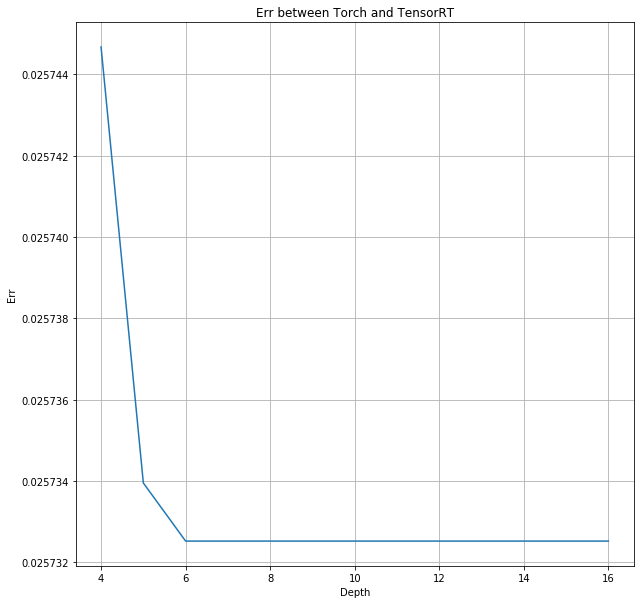

In [7]:
plt.figure(0, figsize=(10,10))
plt.plot(arr_depth[3:], arr[3:])
plt.xlabel("Depth")
plt.ylabel("Err")
plt.grid()
plt.title("Err between Torch and TensorRT")


In [10]:
arr_depth[15]

16

In [14]:
[0, 1, 2][0:2]
[0, 1, 2][2]

2